### Setup

In [1]:
# Install required packages
!pip install -q pymupdf==1.25.3 \
                ratelimit==2.2.1\
                langchain-text-splitters==0.3.6 \
                langchain-core==0.3.41\
                langgraph==0.3.5\
                langchain-google-genai==2.0.11 \
                pymilvus==2.5.5

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.1/415.1 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflic

#### Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Initialize required variables

In [ ]:
GEMINI_API_KEY = "API-KEY" #@param {type: "string"}

In [4]:
# Path to folder containing rag pdfs
rag_files_path = "/content/drive/MyDrive/GenAI_Expts/rag_datasets"

In [5]:
# Path to embeddings jsonl file (if created already), instead of chunking and creating embeddings all over again
embeddings_path = "/content/drive/MyDrive/GenAI_Expts/cleaned_embeddings.jsonl"

#### Import Required Packages

In [61]:
import copy
import fitz
import json
import time
import uuid
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from ratelimit import limits, sleep_and_retry
from typing import List, Annotated, Sequence
from typing_extensions import TypedDict, Annotated
from IPython.display import display, Markdown, Image

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.messages.base import messages_to_dict

from langgraph.graph.message import add_messages
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

from pymilvus import MilvusClient

#### Util functions to load content from drive

In [8]:
def get_files_in_dir(path):
  """Get complete path of the pdf files in dir"""
  files_list = []

  for file in listdir(path):
    file_path = join(path, file)
    if file_path.endswith(".pdf") and isfile(file_path):
      files_list.append(file_path)

  return files_list

In [9]:
def load_embeddings(path):
  """Load embeddings from jsonl file"""
  with open(path, 'r') as json_file:
    json_data = [json.loads(line) for line in json_file]

  return json_data

### Chunking

Simple recursive text chunking that splits text into chunks of size 1000 and an overlap of 200 tokens.
- The chunking done here, is the most simple one and works with pdf text, i.e. pdf containing machine readable text or digital text.
- For pdf containing images or scanned content, another layer like OCR or custom parser should be used. Same applies if other types of files like ppt, docx etc are used.
- Other chunking strategies like context aware chunking, Semantic chunking etc.

To keep things simple, the most basic of basic chunking strategies were used.

In [ ]:
class PDFTextSplitter:
  """Document splitter class for pdf text"""

  def __init__(self, file_uri, chunk_size=1000, chunk_overlap=200):
    """Initialize text splitter with required params"""
    self.file_uri = file_uri
    self.chunk_size = chunk_size
    self.chunk_overlap = chunk_overlap
    self.text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=self.chunk_size,
        chunk_overlap=self.chunk_overlap,
        separators=["\n\n", "\n", " ", ""],
        length_function=len
    )

  def _clean_special_chars(self, text: str):
    """Remove special characters/unicodes in the text"""
    cleaned_text = text.replace("\t\n","").replace("\x08\n","").replace("\xa0","").replace("\t\r","").replace("\uf0b7","")

    return cleaned_text

  def get_page_info(self, pdf_path: str):
    """Get full text content of pdf and page info"""
    doc_id = str(uuid.uuid4())
    full_text = ""
    page_info = []

    pdf_doc = fitz.open(pdf_path)

    for page_num in range(pdf_doc.page_count):
      page = pdf_doc[page_num]
      text = page.get_text()
      page_start_idx = len(full_text)
      full_text += text
      page_end_idx = len(full_text)
      page_info.append({
          "doc_id": doc_id,
          "page_id": page_num,
          "page_number": page_num + 1,
          "start_char_idx": page_start_idx,
          "end_char_idx": page_end_idx,
      })
    full_text = self._clean_special_chars(full_text)

    return doc_id, full_text, page_info

  def get_chunks_with_info(self, pdf_uri: str, pdf_text: str, page_info: list, doc_id: str):
    """Split pdf content to chunks and return metadata dict"""
    chunks = []
    text_chunks = self.text_splitter.split_text(pdf_text)

    start_idx = 0
    chunk_positions = []

    # Find the chunk start and end index in the pdf text
    for chunk in tqdm(text_chunks):
      chunk_start = pdf_text.find(chunk, start_idx)
      if chunk_start == -1:
        continue

      chunk_end = chunk_start + len(chunk)
      chunk_positions.append((chunk_start, chunk_end))
      start_idx = chunk_start + 1

    # Identify which pages the chunk falls under, lowest and highest number of the page will be the page span
    for i, (chunk, (start_pos, end_pos)) in enumerate(zip(text_chunks, chunk_positions)):
      spanning_pages = []
      for page in page_info:
        if (start_pos < page["end_char_idx"] and end_pos > page["start_char_idx"]):
          spanning_pages.append(page["page_number"])

      if not spanning_pages:
        continue

      chunk_data = {
          "doc_id": doc_id,
          "chunk_id": f"{doc_id}/chunks/c{i}",
          "content": chunk,
          "page_span": spanning_pages,
          "chunk_metadata": {
              "start_char_idx": start_pos,
              "end_char_idx": end_pos
          },
          "document_metadata": {
              "url": pdf_uri,
              "title": pdf_uri.split("/")[-1]
          }
      }

      chunks.append(chunk_data)

    return chunks

  def process_documents(self, file_uri: list=[]):
    """Process documents to chunks"""
    if not file_uri:
      file_uri = self.file_uri

    if not isinstance(file_uri, list):
      file_uri = [file_uri]

    chunked_file_data = []
    for pdf_path in file_uri:
      print(f"Processing {pdf_path}")
      doc_id, pdf_text, page_info = self.get_page_info(pdf_path)
      chunks_data = self.get_chunks_with_info(pdf_path, pdf_text, page_info, doc_id)
      chunked_file_data.extend(chunks_data)

    print(f"Chunking completed for {pdf_path}.")
    return chunked_file_data

In [ ]:
document_splitter = PDFTextSplitter(rag_files_path)

In [ ]:
all_files_list = get_files_in_dir(rag_files_path)

In [ ]:
all_docs_chunked_data = document_splitter.process_documents(all_files_list)

Processing /content/drive/MyDrive/GenAI_Expts/rag_datasets/Newwhitepaper_Agents2.pdf


100%|██████████| 60/60 [00:00<00:00, 106589.68it/s]


Processing /content/drive/MyDrive/GenAI_Expts/rag_datasets/Easy_recipes.pdf


100%|██████████| 16/16 [00:00<00:00, 41995.53it/s]


Processing /content/drive/MyDrive/GenAI_Expts/rag_datasets/Introduction_to_climate_change_FINAL_002.pdf


100%|██████████| 15/15 [00:00<00:00, 34211.29it/s]


Processing /content/drive/MyDrive/GenAI_Expts/rag_datasets/understanding-climate-change-2008.pdf


100%|██████████| 77/77 [00:00<00:00, 51247.45it/s]


Processing /content/drive/MyDrive/GenAI_Expts/rag_datasets/Understanding_Climate_Change.pdf


100%|██████████| 92/92 [00:00<00:00, 55426.02it/s]


Processing /content/drive/MyDrive/GenAI_Expts/rag_datasets/LLM Powered Autonomous Agents _ Lil'Log.pdf


100%|██████████| 45/45 [00:00<00:00, 100932.45it/s]


Processing /content/drive/MyDrive/GenAI_Expts/rag_datasets/20 Easy International Recipes.pdf


100%|██████████| 27/27 [00:00<00:00, 82241.25it/s]

Chunking completed for /content/drive/MyDrive/GenAI_Expts/rag_datasets/20 Easy International Recipes.pdf.


In [ ]:
# Seeing the chunk content
all_docs_chunked_data[:2]

[{'doc_id': 'e436348e-a04d-4a66-b325-e7aca5259704',
  'chunk_id': 'e436348e-a04d-4a66-b325-e7aca5259704/chunks/c0',
  'content': 'Agents\nAuthors: Julia Wiesinger, Patrick Marlow \nand Vladimir Vuskovic\nAgents\n2\nSeptember 2024\nAcknowledgements\nReviewers and Contributors\nEvan Huang\nEmily Xue\nOlcan Sercinoglu\nSebastian Riedel\nSatinder Baveja\nAntonio Gulli\nAnant Nawalgaria\nCurators and Editors\nAntonio Gulli\nAnant Nawalgaria\nGrace Mollison \nTechnical Writer\nJoey Haymaker\nDesigner\nMichael Lanning \nIntroduction4\nWhat is an agent?5\nThe model6\nThe tools7\nThe orchestration layer7\nAgents vs. models8\nCognitive architectures: How agents operate 8\nTools: Our keys to the outside world12\nExtensions 13\nSample Extensions 15\nFunctions 18\nUse cases21\nFunction sample code24\nData stores27\nImplementation and application28\nTools recap32\nEnhancing model performance with targeted learning33\nAgent quick start with LangChain35\nProduction applications with Vertex AI agents38

### Embedding

Local models
- all-MiniLM-L6-v2 - faster and mostly accurate
- all-mpnet-base-v2 - slightly better accuracy but slower

API
- Google, OpenAI, Above models with HF Token.

Local models are difficult to run with current specs of my system, since the goal was to run this as an application. So only option is to use APIs, Google's embedding models as they are free and superior and get's the job done.

In [10]:
class EmbeddingClient:
  """Custom class for embedding data with Gemini models"""
  def __init__(self, model_name: str="models/text-embedding-004", embedding_api_key: str=""):
    """Initialize embedding client with required params"""
    self.model_name = model_name
    self.embedding_api_key = embedding_api_key
    self.embedding_instance = GoogleGenerativeAIEmbeddings(model=self.model_name,
                                                           google_api_key=self.embedding_api_key)

  @sleep_and_retry
  @limits(calls=120, period=60)
  def _generate_embedding(self, chunk_content):
    """Helper function to generate embedding with rate limiting"""
    try:
      return self.embedding_instance.embed_query(chunk_content)
    except Exception as e:
      print(e)

  def generate_embeddings(self, chunks_data):
    """Generate embeddings for content"""

    embeddings_data = copy.deepcopy(chunks_data)

    for chunk in tqdm(embeddings_data):
      chunk_content = chunk["content"]
      chunk_embedding = chunk_embedding = self._generate_embedding(chunk_content)
      chunk["chunk_embedding"] = chunk_embedding

    return embeddings_data

  def get_query_embeddings(self, content: str):
    """Generate embeddings for query during runtime"""

    query_embedding = self.embedding_instance.embed_query(text=content)

    return query_embedding

In [ ]:
embedding_instance = EmbeddingClient(embedding_api_key=GEMINI_API_KEY)

In [ ]:
embeddings_data = embedding_instance.generate_embeddings(all_docs_chunked_data)

100%|██████████| 332/332 [02:11<00:00,  2.53it/s]


In [ ]:
with open('cleaned_embeddings.jsonl', 'w') as outfile:
  for entry in embeddings_data:
      json.dump(entry, outfile)
      outfile.write('\n')

### Indexing data to VectorDB
Embeddings can be loaded from the above process or directly from the drive.

For experimentation, once the embeddings are created they are stored as jsonl file and saved in drive. The file can be loaded from next time to avoid chunking and embedding again.

In [11]:
embedding_data = load_embeddings(embeddings_path)

In [12]:
embedding_data[0].keys()

dict_keys(['doc_id', 'chunk_id', 'content', 'page_span', 'chunk_metadata', 'document_metadata', 'chunk_embedding'])

Milvus is a vector database know for it's speed and features. Some of the reasons for choosing Milvus over other vectore databases like ChromaDB,Qdrant etc are,
- Getting familiar with production grade vector db. Although chromdb is simple and light, milvus is used in a lot of production projects. Mostly for it's scalability and features.
- Metadata filtering and parsing - Milvus has better features when it comes to this.
- Typical curiosity to use milvus, since i've experimented with chromadb and other vector db before.

In [18]:
class CustomMilvusClient:
  """Custom class for Milvus Client to create, update and query a milvus collection"""
  def __init__(self, uri: str):
    self.uri = uri
    self.milvus_client = MilvusClient(uri=self.uri)

  def create_collection(self, collection_name: str="", embedding_dimension: int=0, vector_field_name: str="", primary_field_name: str="", max_id_length: int=50):
    """Create collection with given fields into milvus vector db"""
    if self.milvus_client.has_collection(collection_name):
      print(f"Collection with {collection_name} already exists. Over writing existing collection.")
      self.milvus_client.drop_collection(collection_name)

    try:
      self.milvus_client.create_collection(collection_name=collection_name,
                                          dimension=embedding_dimension,
                                          vector_field_name=vector_field_name,
                                          metric_type="COSINE",
                                          primary_field_name=primary_field_name,
                                          id_type="string",
                                          max_length=max_id_length)
      print(f"Collection '{collection_name}' successfully created.")
    except Exception as e:
      print(e)

  def insert_data_to_collection(self, collection_name: str="", data: list=[]):
    """Insert data into created collection in milvus db"""
    if self.milvus_client.has_collection(collection_name):
      self.milvus_client.insert(collection_name=collection_name,
                         data=data)
      print(f"Data successfully inserted to collection '{collection_name}'.")
    else:
      raise ValueError(f"Collection with name '{collection_name}' does not exist. Please insert into another or create a new collection using .create_collection.")

  def query_collection(self, collection_name: str="", query_embedding: list=[], limit: int=5, output_fields: list=[]):
    """Get relevant docs based on similarity between query embedding and vectors in DB"""
    start_time = time.time()
    if self.milvus_client.has_collection(collection_name):
      retriever_result = self.milvus_client.search(collection_name=collection_name,
                                            data=[query_embedding],
                                            limit=limit,
                                            output_fields=output_fields)
      end_time = time.time()
      execution_time = end_time - start_time
      print(f"Retrieved in {execution_time:.6f}s.")
      return retriever_result
    else:
      raise ValueError(f"Collection with {collection_name} does not exist. Please query on another collection or create a new collection using .create_collection.")

In [19]:
retriever_instance = CustomMilvusClient(uri="./my_milvus.db")

In [20]:
retriever_instance.create_collection(collection_name="pdfrag",
                                     embedding_dimension=768,
                                     vector_field_name="chunk_embedding",
                                     primary_field_name="chunk_id")

Collection 'pdfrag' successfully created.


In [21]:
retriever_instance.insert_data_to_collection(collection_name="pdfrag",
                                             data=embedding_data)

Data successfully inserted to collection 'pdfrag'.


### RAG

#### Retriever Setup

In [22]:
# Initalize retriever and embedding clients to use at runtime
retriever_instance = CustomMilvusClient(uri="./my_milvus.db")
embedding_instance = EmbeddingClient(embedding_api_key=GEMINI_API_KEY)

In [23]:
def get_relevant_docs(collection_name: str, query: str, top_n: int=5):
  """Get relevant docs for a given query"""
  query_embedding = embedding_instance.get_query_embeddings(content=query)

  docs = retriever_instance.query_collection(collection_name="pdfrag",
                                             query_embedding=query_embedding,
                                             limit=top_n,
                                             output_fields=["content", "page_span","document_metadata"])

  return docs

In [ ]:
query = "Type of memory in agents?"

In [ ]:
get_relevant_docs("pdf_rag",query)[0]

Retrieved in 0.003377s.


[{'id': 'd07b7f7d-40e7-4aaa-999f-c9d512146bf1/chunks/c14',
  'distance': 0.6619677543640137,
  'entity': {'content': 'experiences) and semantic memory (facts and concepts).\nImplicit / procedural memory: This type of memory is unconscious and involves skills and\nroutines that are performed automatically, like riding a bike or typing on a keyboard.\nFig. 8. Categorization of human memory.\nWe can roughly consider the following mappings:\nSensory memory as learning embedding representations for raw inputs, including text,\nimage or other modalities;\nShort-term memory as in-context learning. It is short and finite, as it is restricted by the\nfinite context window length of Transformer.\nLong-term memory as the external vector store that the agent can attend to at query time,\naccessible via fast retrieval.\nMaximum Inner Product Search (MIPS)\nThe external memory can alleviate the restriction of finite attention span. A standard practice is\nto save the embedding representation of info

In [24]:
def format_sources(relevant_docs: list):
  """Format relevant docs into consumable format by llm"""
  sources = ""
  for i, doc in enumerate(relevant_docs[0]):
    sources += f"<source{i + 1}> {doc['entity']['content']} </source{i + 1}>"

  return sources

def format_citations(relevant_docs: list):

    citations = []
    docs = relevant_docs[0]
    for doc in docs:
        citation_data = {}
        citation_data["id"] = doc["id"]
        citation_data["content"] = doc["entity"]["content"]
        document = doc["entity"]["document_metadata"]
        citation_data["title"] = document["title"]
        citation_data["url"] = document["url"] + "#page=" + str(min(doc["entity"]["page_span"]))
        citations.append(citation_data)

    return citations

def format_citations_to_md(citations: list):
  """Format citations to display"""
  citation_str = ""
  for citation in citations:
    citation_str += f"[{citation['title']}]({citation['url']})<br>"

  return citation_str

In [25]:
format_sources(get_relevant_docs("pdfrag","How to make chilli con carne"))

Retrieved in 0.148348s.


"<source1> 1. Chilli con Carne \n  \n \n \nThis  was  one  of  the  first  easy \nrecipes I learnt to cook and can be \nmastered in just a few attempts! It’s \nhealthy, cheap and tasty and makes \nthe ultimate student food. You can \nmake a large batch of this and then \nstore in the fridge for days or freeze \nfor weeks. \n \n \nIngredients \nGround/minced beef 500g \n1 Large onion chopped \n2-\xad‐3 Cloves of Garlic \n1-\xad‐2 Tins of chopped tomatoes 400g \nSqueeze of tomato puree \n1 teaspoon of chilli powder (or to taste) \n1 teaspoon of ground cumin \ndash of Worcester sauce \nSprinkle of salt and pepper \n1 Chopped red pepper \n1 tin of drained kidney beans 400g \n \nMethod \n1) Fry the onion in a hot pan with oil until nearly brown then add chopped \ngarlic \n2) Add the mince and stir until brown -\xad‐ drain any excess fat if desired \n3) Add all dried spices and seasoning then reduce heat and add chopped \ntomatoes \n4) Stir well and add tomato puree and worcester sauce then 

In [27]:
format_citations(get_relevant_docs("pdfrag","How to make chilli con carne"))

Retrieved in 0.004236s.


[{'id': '3158c1f0-40fd-4ad2-aa26-08032d4e1d17/chunks/c1',
  'content': '1. Chilli con Carne \n  \n \n \nThis  was  one  of  the  first  easy \nrecipes I learnt to cook and can be \nmastered in just a few attempts! It’s \nhealthy, cheap and tasty and makes \nthe ultimate student food. You can \nmake a large batch of this and then \nstore in the fridge for days or freeze \nfor weeks. \n \n \nIngredients \nGround/minced beef 500g \n1 Large onion chopped \n2-\xad‐3 Cloves of Garlic \n1-\xad‐2 Tins of chopped tomatoes 400g \nSqueeze of tomato puree \n1 teaspoon of chilli powder (or to taste) \n1 teaspoon of ground cumin \ndash of Worcester sauce \nSprinkle of salt and pepper \n1 Chopped red pepper \n1 tin of drained kidney beans 400g \n \nMethod \n1) Fry the onion in a hot pan with oil until nearly brown then add chopped \ngarlic \n2) Add the mince and stir until brown -\xad‐ drain any excess fat if desired \n3) Add all dried spices and seasoning then reduce heat and add chopped \ntomatoes 

In [30]:
display(Markdown(format_citations_to_md(format_citations(get_relevant_docs("pdfrag","How to make chilli con carne")))))

Retrieved in 0.003079s.


[Easy_recipes.pdf](/content/drive/MyDrive/GenAI_Expts/rag_datasets/Easy_recipes.pdf#page=2)<br>[Easy_recipes.pdf](/content/drive/MyDrive/GenAI_Expts/rag_datasets/Easy_recipes.pdf#page=1)<br>[Easy_recipes.pdf](/content/drive/MyDrive/GenAI_Expts/rag_datasets/Easy_recipes.pdf#page=3)<br>[Easy_recipes.pdf](/content/drive/MyDrive/GenAI_Expts/rag_datasets/Easy_recipes.pdf#page=3)<br>[Easy_recipes.pdf](/content/drive/MyDrive/GenAI_Expts/rag_datasets/Easy_recipes.pdf#page=9)<br>

#### Intialize LLM

In [31]:
LLM_CONFIGS = {
    "gemini-1.5-flash": {
        "model": "gemini-1.5-flash-002",
        "max_output_tokens": 1024,
        "temperature": 0.0,
    },
    "gemini-1.5-pro": {
        "model": "gemini-1.5-pro-002",
        "max_output_tokens": 1024,
        "temperature": 1.0,
    },
    "gemini-2.0-flash": {
        "model": "gemini-2.0-flash-001",
        "max_output_tokens": 1024,
        "temperature": 0.0,
    }
}

In [32]:
chat_model = ChatGoogleGenerativeAI(**LLM_CONFIGS["gemini-2.0-flash"],google_api_key=GEMINI_API_KEY)

#### Prompts

In [45]:
router_template = """You are a helpful assitant whose purpose is to help users with their queries.
Given user question and previous conversation history, utlize the appropriate tools where required to help them.
Understand the user question and identify which tools are more suitable to help them and use it accordingly.

User Question: {user_query}
"""
router_prompt = ChatPromptTemplate.from_messages([
    ("system", router_template),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{user_query}"),
])

In [46]:
rag_template = """You are a friendly and helpful chat bot. Your role is to help users by answering questions based on the sources provided.
Maintain a friendly and supportive tone while providing accurate and helpful responses. Utilize the provided conversation history to understand previous interactions.
Avoid adding any other explanation.
Sources: {sources}

Conversation History: {chat_history}

User Query: {user_query}
Response:
"""
rag_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_template),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{user_query}"),
])
rag_chain = rag_prompt | chat_model | StrOutputParser()

In [47]:
# Prompt for rewriting query based on previous history
query_rewrite_template = """Given the following conversation history and user followup question, rephrase the user query to be a standalone question.
The rephrased question should be understood without the chat history and should be meaningful and complete on its own.
If the query is independent and is not related to the chat history, then return it as is. In any other case, rewrite the query.

Conversation History: {chat_history}
User Query: {question}

Standalone Question:
"""
query_rewrite_prompt = ChatPromptTemplate.from_messages([
    ("system", query_rewrite_template),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{question}"),
])
rewrite_chain = query_rewrite_prompt | chat_model | StrOutputParser()

#### Graph

In [48]:
@tool
def get_relevant_docs_tool(query: str) -> list:
  """Utilize this function if user asks any questions related to climate change, recipes and LLMs terminology.
  This tool searches and return information about recipes, LLM terminology and climate change.
  For all user questions, utlize this tool to get relevant sources for answering user query.
  Args:
      query: The exact question asked by the user without any modifications
  """
  print("---CALL RETRIEVER--")
  collection_name = "pdfrag"
  relevant_docs = get_relevant_docs(collection_name=collection_name,
                                    query=query)
  # reranking logic etc can be added

  return relevant_docs

In [49]:
tools = [get_relevant_docs_tool]

In [50]:
class AgentState(TypedDict):

  messages: Annotated[Sequence[BaseMessage], add_messages]
  chat_messages: Annotated[Sequence[BaseMessage], add_messages]
  chat_history: Sequence[BaseMessage]
  relevant_docs: List
  tool_call: dict
  bot_response: str
  rewritten_query: str

In [51]:
def router(state):
  """Call router to decide which tool to user"""

  print("---CALL ROUTER---")

  messages = state["messages"]
  chat_history = state["chat_history"]
  user_query = messages[0].content

  model_with_tools = chat_model.bind_tools(tools)

  router_chain = router_prompt | model_with_tools

  response = router_chain.invoke({
      "chat_history": chat_history,
      "user_query": user_query
  })

  return {
      "messages": [response],
      "chat_messages": messages,
      "tool_call": response.tool_calls
  }

In [52]:
def tool_check_condition(state):
  print("---CHECK TOOL CALL---")
  print(state["tool_call"])

  if state.get("tool_call"):
    for tool_call in state.get("tool_call"):
      if tool_call.get("name") == "get_relevant_docs_tool":
        return "retrieve_tool"
      elif tool_call.get("name") == "other_tool":
        #should modify graph accordingly
        return "other_tool"
  else:
    return "END"

In [53]:
def rewrite(state):
  """Rewrite query"""

  print("---CALL REWRITE---")

  messages = state["messages"]
  user_query = messages[0].content
  rewritten_query = ""
  chat_history = state["chat_history"]

  if chat_history:
    print("---REWRITING USING HISTORY---")
    rewritten_query = rewrite_chain.invoke({
        "chat_history": chat_history,
        "question": user_query
    })
    print("---REWRITTEN QUERY---")
    print(rewritten_query)

    return {
        "rewritten_query": rewritten_query
    }
  else:
    print("-HISTORY NOT FOUND-")
    return {
        "rewritten_query": ""
    }

In [55]:
def generate(state):
  """Generate response to user query based on retrieved sources"""

  print("---CALL GENERATE---")
  messages = state["messages"]
  chat_history = state.get("chat_history")
  tool_response = json.loads(messages[-1].content)

  user_query = messages[0].content
  print("---QUERY---", user_query)
  rewritten_query = state.get("rewritten_query")
  if rewritten_query:
    print("---USING REWRITTEN QUERY---", rewritten_query)
    user_query = rewritten_query

  sources = format_sources(tool_response)

  response = rag_chain.invoke({
      "sources": sources,
      "user_query": user_query,
      "chat_history": chat_history
  })

  print(response)

  return {
      "messages": [AIMessage(content=response)],
      "chat_messages": [AIMessage(content=response)],
      "relevant_docs": format_citations(tool_response),
      "bot_response": response,
      "rewritten_query": rewritten_query
  }

In [56]:
workflow = StateGraph(AgentState)

workflow.add_node("router", router)
retriever = ToolNode([get_relevant_docs_tool])
workflow.add_node("retriever", retriever)
workflow.add_node("rewrite",rewrite)
workflow.add_node("generate", generate)

workflow.add_edge(START, "router")
workflow.add_conditional_edges(
    "router",
    tool_check_condition,
    {
        "retrieve_tool": "rewrite",
        "END": END
    }

)
workflow.add_edge("rewrite","retriever")
workflow.add_edge("retriever", "generate")
workflow.add_edge("generate", END)

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	router(router)
	retriever(retriever)
	rewrite(rewrite)
	generate(generate)
	__end__([<p>__end__</p>]):::last
	__start__ --> router;
	generate --> __end__;
	retriever --> generate;
	rewrite --> retriever;
	router -. &nbsp;retrieve_tool&nbsp; .-> rewrite;
	router -. &nbsp;END&nbsp; .-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



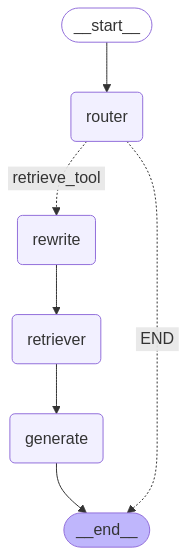

In [62]:
graph = workflow.compile()
print(graph.get_graph().draw_mermaid())
Image(graph.get_graph().draw_mermaid_png())

In [64]:
def chat_session(query, chat_history):
  user_input = {
      "messages": [
          ("user", query)
      ],
      "chat_history": chat_history
  }

  graph_response = graph.invoke(user_input)

  return graph_response.get("bot_response"), graph_response.get("chat_messages")

In [65]:
response, history_0 = chat_session("How do i make a chili con carne?", [])

---CALL ROUTER---
---CHECK TOOL CALL---
[{'name': 'get_relevant_docs_tool', 'args': {'query': 'How do i make a chili con carne?'}, 'id': '11a199e7-55be-4cdd-86e2-8146764afb09', 'type': 'tool_call'}]
---CALL REWRITE---
-HISTORY NOT FOUND-
---CALL RETRIEVER--
Retrieved in 0.004653s.
---CALL GENERATE---
---QUERY--- How do i make a chili con carne?
Chili con Carne Recipe:

**Ingredients:**

*   Ground/minced beef 500g
*   1 Large onion chopped
*   2-3 Cloves of Garlic
*   1-2 Tins of chopped tomatoes 400g
*   Squeeze of tomato puree
*   1 teaspoon of chilli powder (or to taste)
*   1 teaspoon of ground cumin
*   Dash of Worcester sauce
*   Sprinkle of salt and pepper
*   1 Chopped red pepper
*   1 tin of drained kidney beans 400g

**Method:**

1.  Fry the onion in a hot pan with oil until nearly brown then add chopped garlic
2.  Add the mince and stir until brown - drain any excess fat if desired
3.  Add all dried spices and seasoning then reduce heat and add chopped tomatoes
4.  Stir well

In [66]:
followup_response, history_1 = chat_session("Tell me how to make a carbonara", history_0)

---CALL ROUTER---
---CHECK TOOL CALL---
[{'name': 'get_relevant_docs_tool', 'args': {'query': 'how to make carbonara'}, 'id': '70e21a4e-e045-4232-aaad-5ae8ef49bb0a', 'type': 'tool_call'}]
---CALL REWRITE---
---REWRITING USING HISTORY---
---REWRITTEN QUERY---
How do I make a carbonara?
---CALL RETRIEVER--
Retrieved in 0.002855s.
---CALL GENERATE---
---QUERY--- Tell me how to make a carbonara
---USING REWRITTEN QUERY--- How do I make a carbonara?
Carbonara al funghi Recipe:

**Ingredients**

*   4 x rashers streaky bacon, chopped
*   10g dried porcini mushrooms
*   4x closed cup mushrooms (25g each), thinly sliced
*   90g of value spaghetti
*   1 egg, beaten
*   30g of Parmesan cheese, grated
*   2 tsp olive oil
*   1/2 x small garlic clove, finely chopped

**Method**

1.  Soak the porcini mushrooms in hot water for 20 minutes. Drain, chop and set aside.
2.  Mix the beaten egg and two thirds of the Parmesan cheese in a large bowl to make the Carbonara sauce. Season with salt and pepper.


In [67]:
followup_response, history_2 = chat_session("Are there any common ingredients between the recipes?", history_0+history_1)

---CALL ROUTER---
---CHECK TOOL CALL---
[{'name': 'get_relevant_docs_tool', 'args': {'query': 'common ingredients between chili con carne and carbonara recipes'}, 'id': '88c6b348-6085-4d66-bf0c-fe47f3e42105', 'type': 'tool_call'}]
---CALL REWRITE---
---REWRITING USING HISTORY---
---REWRITTEN QUERY---
What ingredients are common between the chili con carne recipe and the carbonara recipe that you provided?
---CALL RETRIEVER--
Retrieved in 0.002886s.
---CALL GENERATE---
---QUERY--- Are there any common ingredients between the recipes?
---USING REWRITTEN QUERY--- What ingredients are common between the chili con carne recipe and the carbonara recipe that you provided?
The common ingredients between the Chili con Carne and Carbonara al funghi recipes are:

*   Garlic
*   Salt and pepper


#### Stream

In [69]:
def chat_session_stream(query, chat_history):
    user_input = {
        "messages": [
            ("user", query)
        ],
        "chat_history": chat_history
    }

    graph_response = graph.stream(user_input, stream_mode="messages")
    for message_chunk, langgraph_data in graph_response:
        print("--STREAM--")
        if langgraph_data["langgraph_node"] == "generate":
            yield(message_chunk.content)

    return "", ""

In [70]:
response = chat_session_stream("How do i make a chili con carne?", [])
for chunk in response:
    print(chunk)

---CALL ROUTER---
--STREAM--
---CHECK TOOL CALL---
[{'name': 'get_relevant_docs_tool', 'args': {'query': 'How do i make a chili con carne?'}, 'id': '1faf8cdf-f344-47d5-a172-0655d238ba76', 'type': 'tool_call'}]
---CALL REWRITE---
-HISTORY NOT FOUND-
---CALL RETRIEVER--
Retrieved in 0.002894s.
--STREAM--
---CALL GENERATE---
---QUERY--- How do i make a chili con carne?
--STREAM--
Here
--STREAM--
's how you can make Chilli con Carne:

**Ingredients:**

*   
--STREAM--
Ground/minced beef 500g
*   1 Large onion
--STREAM--
 chopped
*   2-3 Cloves of Garlic
*   1-2 Tins of chopped tomatoes 400g
*   Squeeze
--STREAM--
 of tomato puree
*   1 teaspoon of chilli powder (or to taste)
*   1 teaspoon of ground cumin
*   dash of Worcester sauce
--STREAM--
*   Sprinkle of salt and pepper
*   1 Chopped red pepper
*   1 tin of drained kidney beans 400g

**Method:**

1.  Fry the onion in a hot pan with oil until
--STREAM--
 nearly brown then add chopped garlic
2.  Add the mince and stir until brown - drai